
Image: data/asl_alphabet/Q/Q485.jpg
  array.shape = (200, 200, 3), dtype = uint8
  pixel range = 0 … 255


I0000 00:00:1746878710.736964 11806281 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
W0000 00:00:1746878710.743104 11807700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746878710.747793 11807710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


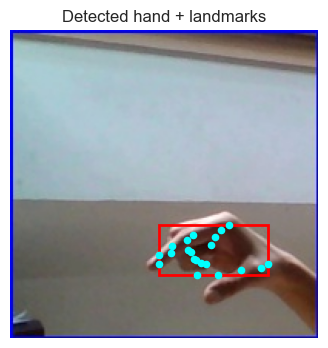


Image: data/asl_alphabet/U/U1784.jpg
  array.shape = (200, 200, 3), dtype = uint8
  pixel range = 0 … 255


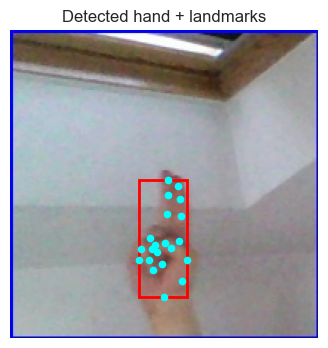


Image: data/asl_alphabet/E/E1934.jpg
  array.shape = (200, 200, 3), dtype = uint8
  pixel range = 0 … 255


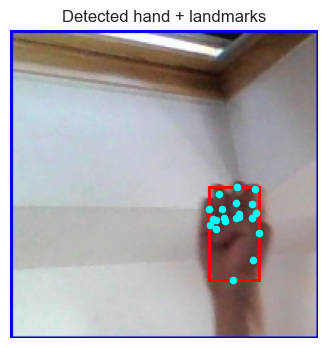


Image: data/asl_alphabet/D/D792.jpg
  array.shape = (200, 200, 3), dtype = uint8
  pixel range = 0 … 255


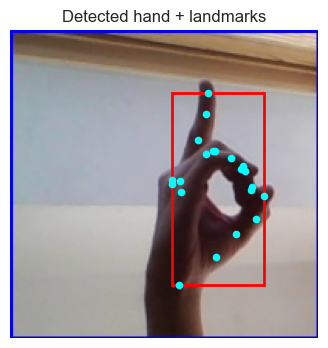


Image: data/asl_alphabet/D/D2012.jpg
  array.shape = (200, 200, 3), dtype = uint8
  pixel range = 0 … 255


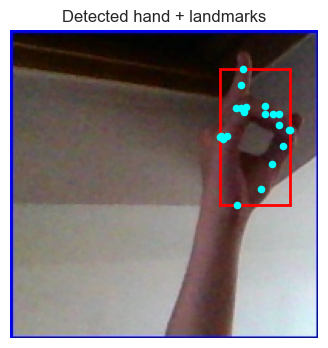

In [3]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import mediapipe
from torchvision import datasets
from matplotlib.patches import Rectangle

# ── 1) Set up MediaPipe Hands ──────────────────────────────────────────────────
mp_hands = mediapipe.solutions.hands.Hands(
    static_image_mode=True,  # we’re doing single‐image inference
    max_num_hands=1,  # only care about one hand
    min_detection_confidence=0.1,  # 20% threshold
    min_tracking_confidence=0.1
)


# ── 2) Helper to draw a box & landmarks ────────────────────────────────────────
def draw_hand(ax, landmarks, image_shape):
    h, w, _ = image_shape
    # normalized landmarks → pixel coords
    pts = np.array([[lm.x * w, lm.y * h] for lm in landmarks.landmark])
    xs, ys = pts[:, 0], pts[:, 1]
    # bounding box from landmark extents
    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()
    # draw rectangle

    rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                     fill=False, edgecolor="red", linewidth=2)
    ax.add_patch(rect)
    # scatter landmarks
    ax.scatter(xs, ys, c="cyan", s=20)


# ── 3) Debug one image ─────────────────────────────────────────────────────────
def debug_image(path):
    # Load with PIL → ensure RGB
    img_pil = Image.open(path).convert("RGB")
    # Convert to numpy uint8, shape H×W×3 channel‐last
    img = np.array(img_pil)

    # Print out exactly what MediaPipe sees
    print(f"\nImage: {path}")
    print(f"  array.shape = {img.shape}, dtype = {img.dtype}")
    print(f"  pixel range = {img.min()} … {img.max()}")
    assert img.dtype == np.uint8 and img.shape[2] == 3, "Expected uint8 RGB H×W×3"

    # Run MediaPipe Hands
    results = mp_hands.process(img)

    # Show original
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img)
    ax.axis("off")

    if not results.multi_hand_landmarks:
        ax.set_title("No hand detected")
        plt.show()
        return

    # Draw the first hand’s box + landmarks
    draw_hand(ax, results.multi_hand_landmarks[0], img.shape)
    ax.set_title("Detected hand + landmarks")
    plt.show()


# ── 4) Pick & debug 5 random ASL images ────────────────────────────────────────
root = "data/asl_alphabet"
ds = datasets.ImageFolder(root=root, transform=None)
all_paths, _ = zip(*ds.samples)

for img_path in random.sample(all_paths, 5):
    debug_image(img_path)


In [12]:
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets, transforms
import mediapipe
from concurrent.futures import ThreadPoolExecutor

# ── 1) Reproducibility ──────────────────────────────────────────────────────────
seed = 42
random.seed(seed)
np.random.seed(seed)

# ── 2) MediaPipe Hands setup ──────────────────────────────────────────────────
mp_hands = mediapipe.solutions.hands.Hands(
    static_image_mode=True,  # single‐image inference
    max_num_hands=1,  # we only care about a single hand
    min_detection_confidence=0.1,  # 20% threshold
    min_tracking_confidence=0.1,
    model_complexity=0
)

# ── 3) Preprocessing transform ─────────────────────────────────────────────────
# We only use this to resize for consistency; MediaPipe wants the original uint8 image
tf = transforms.Compose([
    transforms.Resize((256, 256)),
])

# ── 4) Load ASL dataset & 80/20 split into train/dev ────────────────────────────
root_asl = "data/asl_alphabet"
ds_asl = datasets.ImageFolder(root=root_asl, transform=None)
classes = ds_asl.classes
class_to_idx = ds_asl.class_to_idx

paths, labels = zip(*ds_asl.samples)
p_train, p_dev, y_train, y_dev = train_test_split(
    paths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=seed,
)

# ── 5) Load synthetic test set using same class_to_idx ──────────────────────────
root_test = "data/synthetic_test"
p_test, y_test = [], []
for cls in classes:
    cls_dir = os.path.join(root_test, cls)
    if not os.path.isdir(cls_dir):
        continue
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            p_test.append(os.path.join(cls_dir, fname))
            y_test.append(class_to_idx[cls])


# ── 6) Single‐image pipeline with MediaPipe ────────────────────────────────────
def extract_landmarks(p_lbl):
    """
    Returns:
      vec64: np.ndarray of shape (64,)
        - first 63 entries: [x1',y1',z1, x2',y2',z2, …, x21',y21',z21]
            where (xi', yi') are landmarks re‐normalized into the bounding box
        - last entry: detection confidence ∈ [0,1] (0 if no hand)
      lbl: the class index
    """
    path, lbl = p_lbl
    img_pil = Image.open(path).convert("RGB")
    # resize for consistency (optional)
    img_resized = tf(img_pil)
    # MediaPipe wants uint8 H×W×3 numpy
    img = np.array(img_resized, dtype=np.uint8)

    results = mp_hands.process(img)
    if not results.multi_hand_landmarks:
        # no hand detected
        vec63 = np.zeros(63, dtype=np.float32)
        conf = 0.0
    else:
        # grab first hand
        hand_landmarks = results.multi_hand_landmarks[0]
        # also grab detection confidence
        conf = float(results.multi_handedness[0].classification[0].score)

        # full‐image landmarks → pixel coords
        h, w, _ = img.shape
        pts = np.array([[lm.x * w, lm.y * h, lm.z]
                        for lm in hand_landmarks.landmark], dtype=np.float32)

        # bounding box in pixel coords
        x1, y1 = pts[:, 0].min(), pts[:, 1].min()
        x2, y2 = pts[:, 0].max(), pts[:, 1].max()

        # width/height (avoid zero‐div)
        bw = max(x2 - x1, 1e-3)
        bh = max(y2 - y1, 1e-3)

        # re‐normalize each landmark into that box
        norm_pts = []
        for x_px, y_px, z in pts:
            x_n = (x_px - x1) / bw
            y_n = (y_px - y1) / bh
            norm_pts.extend([x_n, y_n, z])
        vec63 = np.array(norm_pts, dtype=np.float32)

    vec64 = np.concatenate([vec63, [conf]], axis=0)
    return vec64, lbl


def build_features(paths, labels):
    feats = []
    for pair in tqdm(zip(paths, labels), total=len(paths), desc="Extract landmarks"):
        feats.append(extract_landmarks(pair))
    X, y = zip(*feats)
    return np.vstack(X), np.array(y, dtype=int)


# ── 8) Extract features for train/dev/test ─────────────────────────────────────
X_train, y_train = build_features(p_train, y_train)
X_dev, y_dev = build_features(p_dev, y_dev)
X_test, y_test = build_features(p_test, y_test)

print(f"Samples → Train: {len(y_train)}, Dev: {len(y_dev)}, Test: {len(y_test)}")
print(f"Feature dimension: {X_train.shape[1]}")  # should be 64


I0000 00:00:1746879844.210603 11806281 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
W0000 00:00:1746879844.215684 11824636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746879844.218273 11824636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Extract landmarks: 100%|██████████| 2700/2700 [00:45<00:00, 59.72it/s]

Samples → Train: 69622, Dev: 17406, Test: 2700
Feature dimension: 64


In [42]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from itertools import product
from joblib import Parallel, delayed
import os
from tqdm import tqdm

import multiprocessing as mp

# 1) Define models + parameter grids
model_specs = {
    # "LogisticRegression": {
    #     "cls": LogisticRegression,
    #     "init_kwargs": {"random_state": seed, "max_iter": 1000, "solver": "saga"},
    #     "param_grid": {
    #         "penalty": ['l2', 'l1'],
    #         "C": [0.01, 0.1, 1.0],
    #     }
    # },
    # "SVC": {
    #     "cls": SVC,
    #     "init_kwargs": {"random_state": seed},
    #     "param_grid": {
    #         "kernel": ["linear", "rbf"],
    #         "C": [0.1, 1.0],
    #         "gamma": ["scale"],
    #     }
    # },
    "RandomForest": {
        "cls": RandomForestClassifier,
        "init_kwargs": {"random_state": seed},
        "param_grid": {
            "n_estimators": [50, 100, 200, 300],
            "max_depth": [10, 20, None],
            "max_features": [0.05, 0.1, 0.2],
            "min_samples_leaf": [2, 4, 8],
        }
    },
    # "HistGradientBoosting": {
    #     "cls": HistGradientBoostingClassifier,
    #     "init_kwargs": {"random_state": seed},
    #     "param_grid": {
    #         "learning_rate": [0.01, 0.1],
    #         "max_iter": [100, 300],
    #         "max_depth": [5, 10],
    #     }
    # },
}

tasks = []
for name, spec in model_specs.items():
    keys, values = zip(*spec["param_grid"].items())
    for combo in product(*values):
        params = dict(zip(keys, combo))
        tasks.append((name, spec["cls"], spec["init_kwargs"], params))


# 3) Worker that builds, fits, scores
def worker(name, Cls, init_kwargs, params):
    est = Cls(**init_kwargs)
    est.set_params(**params)
    est.fit(X_train, y_train)
    preds = est.predict(X_dev)
    f1 = f1_score(y_dev, preds, average="macro")
    return name, params, f1


# 4) Launch thread pool & print as each finishes
print(f"Running {len(tasks)} tasks in parallel (threads)…")
results = []
with ThreadPoolExecutor(max_workers=os.cpu_count() - 1 or 1) as exe:
    futures = [
        exe.submit(worker, name, Cls, init_kwargs, params)
        for name, Cls, init_kwargs, params in tasks
    ]
    for i, fut in enumerate(as_completed(futures)):
        name, params, f1 = fut.result()
        print(f"{i / len(futures) :4.2f} -- {name:20s} {params} → Dev macro-F1 = {f1:.4f}")
        results.append((name, params, f1))

# 5) Pick best per model & retrain
best_estimators = {}
for name, spec in model_specs.items():
    subset = [(f1, params) for m, params, f1 in results if m == name]
    best_f1, best_params = max(subset, key=lambda x: x[0])
    print(f"→ Best Dev macro-F1 for {name}: {best_f1 * 100:.2f}% with {best_params}")

    final = spec["cls"](**spec["init_kwargs"])
    final.set_params(**best_params)
    final.fit(X_train, y_train)
    best_estimators[name] = final

Running 108 tasks in parallel (threads)…
0.00 -- RandomForest         {'n_estimators': 50, 'max_depth': 10, 'max_features': 0.05, 'min_samples_leaf': 8} → Dev macro-F1 = 0.8367
0.01 -- RandomForest         {'n_estimators': 50, 'max_depth': 10, 'max_features': 0.05, 'min_samples_leaf': 4} → Dev macro-F1 = 0.8366
0.02 -- RandomForest         {'n_estimators': 50, 'max_depth': 10, 'max_features': 0.05, 'min_samples_leaf': 2} → Dev macro-F1 = 0.8376
0.03 -- RandomForest         {'n_estimators': 50, 'max_depth': 20, 'max_features': 0.05, 'min_samples_leaf': 8} → Dev macro-F1 = 0.8490
0.04 -- RandomForest         {'n_estimators': 50, 'max_depth': 20, 'max_features': 0.05, 'min_samples_leaf': 4} → Dev macro-F1 = 0.8539
0.05 -- RandomForest         {'n_estimators': 50, 'max_depth': 20, 'max_features': 0.05, 'min_samples_leaf': 2} → Dev macro-F1 = 0.8573
0.06 -- RandomForest         {'n_estimators': 50, 'max_depth': 10, 'max_features': 0.1, 'min_samples_leaf': 4} → Dev macro-F1 = 0.8417
0.06 -- 


KeyboardInterrupt



In [49]:
rfc = RandomForestClassifier(n_estimators=200, max_depth=None, max_features=0.2, min_samples_leaf=2, random_state=42,
                             n_jobs=os.cpu_count() - 1 or 1)
rfc.fit(X_train, y_train)
best_estimators = {'RandomForest': rfc}


=== RandomForestClassifier on Dev set ===
Dev Accuracy: 81.65%, Macro-F1: 86.08%
              precision    recall  f1-score   support

           A     0.9323    0.6883    0.7919       600
           B     0.9883    0.7067    0.8241       600
           C     0.9453    0.7200    0.8174       600
           D     0.9767    0.9083    0.9413       600
           E     0.9615    0.7900    0.8673       600
           F     0.9928    0.9250    0.9577       600
           G     0.9959    0.7987    0.8864       601
           H     0.9812    0.8702    0.9224       601
           I     0.9903    0.8533    0.9167       600
           J     0.9880    0.8267    0.9002       600
           K     0.9945    0.8952    0.9422       601
           L     0.9908    0.9017    0.9442       600
           M     0.9287    0.7600    0.8359       600
           N     0.8978    0.6000    0.7193       600
           O     0.9718    0.8037    0.8798       601
           P     0.9731    0.7850    0.8690       600

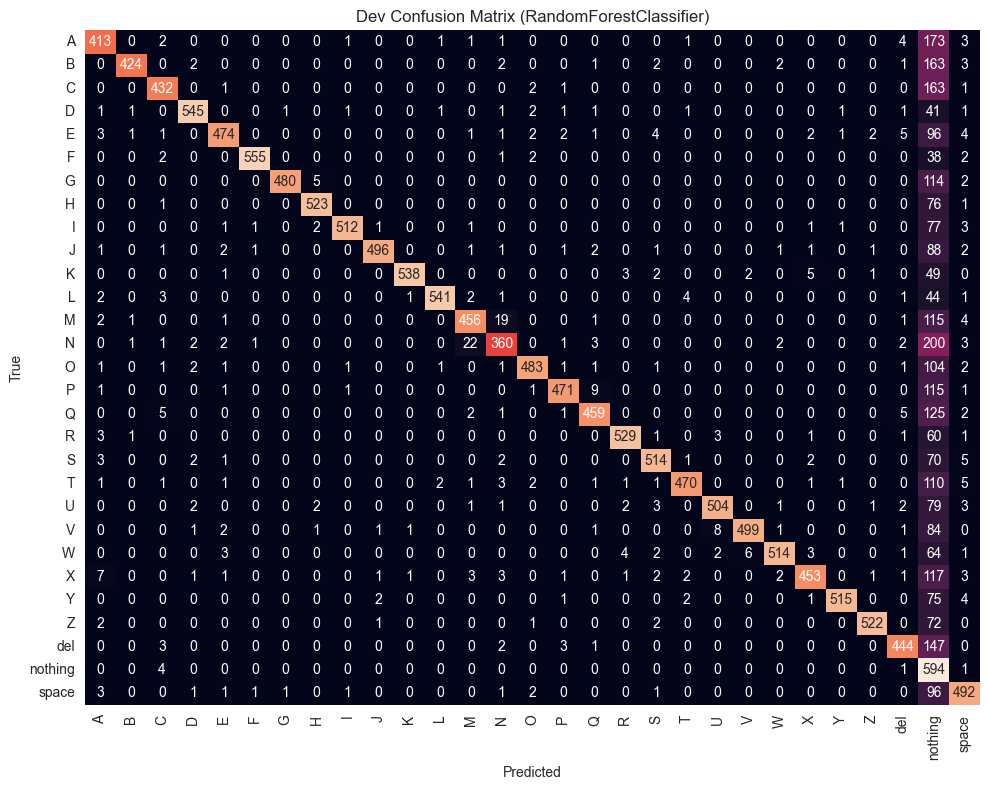


=== RandomForestClassifier on Test set ===
Test Accuracy: 39.04%, Macro-F1: 36.34%
              precision    recall  f1-score   support

           A     0.5124    0.6200    0.5611       100
           B     0.9259    0.5000    0.6494       100
           C     0.0625    0.0400    0.0488       100
           D     0.3137    0.3200    0.3168       100
           E     0.4359    0.8500    0.5763       100
           F     0.9778    0.4400    0.6069       100
           G     0.0000    0.0000    0.0000       100
           H     0.9636    0.5300    0.6839       100
           I     0.3915    0.8300    0.5321       100
           J     0.0000    0.0000    0.0000       100
           K     0.8679    0.4600    0.6013       100
           L     0.9661    0.5700    0.7170       100
           M     0.0139    0.0200    0.0164       100
           N     0.0000    0.0000    0.0000       100
           O     0.4766    0.5100    0.4928       100
           P     0.5000    0.1300    0.2063       1

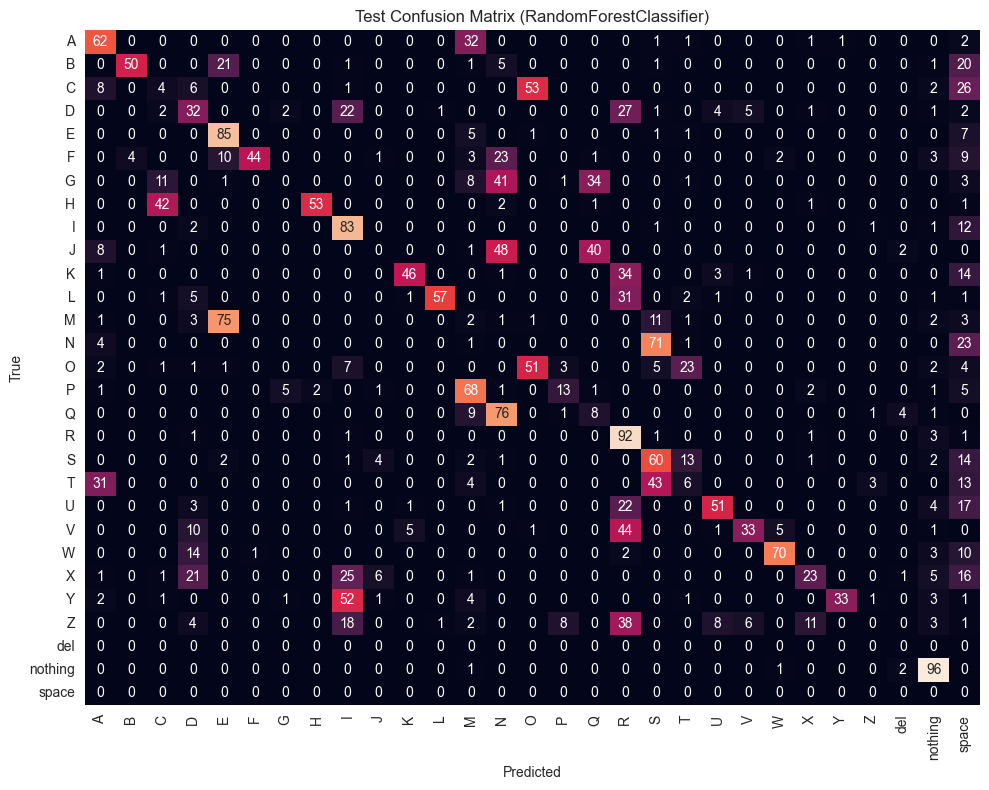

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score


def evaluate(estimator, X, y, split="Dev"):
    cls_name = estimator.__class__.__name__
    preds = estimator.predict(X)
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds, average="macro")
    print(f"\n=== {cls_name} on {split} set ===")
    print(f"{split} Accuracy: {acc * 100:.2f}%, Macro-F1: {f1 * 100:.2f}%")
    print(classification_report(
        y, preds,
        labels=list(range(len(classes))),
        target_names=classes,
        zero_division=0,
        digits=4
    ))
    cm = confusion_matrix(y, preds, labels=list(range(len(classes))))
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=classes,
        yticklabels=classes,
        cbar=False
    )
    plt.title(f"{split} Confusion Matrix ({cls_name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


for name, est in best_estimators.items():
    evaluate(est, X_dev, y_dev, "Dev")
    evaluate(est, X_test, y_test, "Test")